# Projecting demographics onto population

For the population grids we have, project country-wise demographic information. For example, say we want to consider only population in a given age range, we want to apply the % of population in that age band to each population point.

## Method

- Load up demographic data from UN ESA WPP
- Sum fields according to dimension of interest. At first will just look at population over 5 years old for the temperature exposure. Later consider other demographics as needed.
- Join the calculated field to a world shapefile table (using geopandas) using the UN numerical country identifier.
- Using rasterio, rasterise the vector layer into an image matching the population grid.
- The resulting array can by used to multiply the outputs of the weather-population count projection.

## TODO

- Decide how to address demographics over time - do I want to have a grid for each year in the 2000-2015 range? Probably overkill, although for indicators related to old age, this might matter in places with rapidly aging populations (where even 15 years might be enough to see a meaningful change related to change in age structure). This would be more pronounced when extrapolating back further - I think I could extrapolate population grids roughly linearly back to 1990 without much trouble and the UN data covers that no problem. 
- For the Urban/Rural area (used in the labor productivity indicator), need to use a different demographics file and sum a bit more manually. HOWEVER I think there is actually a NASA grid file that does this already and might be more appropriate, since it would mask out the cities rather than just giving a national average. => Double checked, actually this does not seem to be the case. Just use the area indicators from Population Quinquennial

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import rasterio
import matplotlib.pyplot as plt
from rasterio import features
from numba import jit
from affine import Affine

import population_tools
from config import DATA_SRC, POP_DATA_SRC, HUMANS_SRC, COUNTRY_POLY_SHP

## Demographic data

For 'population over X age', use the stock indicators from https://esa.un.org/unpd/wpp/Download/Standard/ASCII/
Description https://esa.un.org/unpd/wpp/DVD/Files/1_Indicators%20(Standard)/ASCII_FILES/WPP2015_DB02_Stock_Indicators.txt

To get 'population over 5' need to combine columns 15-100 with 

In [294]:
# un_demographics = pd.read_csv(POP_DATA_SRC / 'UN' / 'WPP2015_INT_F2B_Annual_Population_Indicators_Percentage.csv')
# un_demographics = pd.read_csv(POP_DATA_SRC / 'UN' / 'WPP2015_INT_F3_Population_Annual_Single_Medium.csv')


# un_demographics = pd.read_csv(POP_DATA_SRC / 'UN' / 'WPP2015_DB03_Population_Quinquennial.csv')
un_demographics = pd.read_csv(POP_DATA_SRC / 'UN' / 'WPP2015_DB02_Stock_Indicators.csv')
un_demographics = un_demographics.set_index('LocID')
un_demographics.head()

,Location,VarID,Variant,Time,MidPeriod,PopTotal,PopMale,PopFemale,TDepR1564,TDepR2064,...,pFemale_25_100,pFemale_50_100,pFemale_60_100,pFemale_65_100,pFemale_70_100,pFemale_75_100,pFemale_80_100,pFemale_85_100,pFemale_90_100,pPopFemale
LocID,,,,,,,,,,,,,,,,,,,,,
4,Afghanistan,2,Medium,1950,1950.5,7752.118,4099.241,3652.877,78.24,117.42,...,38.13,10.48,4.65,2.65,1.28,0.48,0.13,NaN,NaN,100.0
4,Afghanistan,2,Medium,1955,1955.5,8270.024,4319.041,3950.983,79.53,119.91,...,37.86,10.29,4.60,2.68,1.34,0.53,0.15,NaN,NaN,100.0
4,Afghanistan,2,Medium,1960,1960.5,8994.793,4649.713,4345.080,81.72,123.32,...,37.47,10.10,4.54,2.66,1.36,0.56,0.17,NaN,NaN,100.0
4,Afghanistan,2,Medium,1965,1965.5,9935.358,5096.485,4838.873,83.96,127.32,...,36.99,9.90,4.47,2.64,1.37,0.58,0.19,NaN,NaN,100.0
4,Afghanistan,2,Medium,1970,1970.5,11121.097,5674.218,5446.879,88.13,131.35,...,36.46,9.71,4.41,2.62,1.37,0.59,0.20,NaN,NaN,100.0


### Select a year or range of years. (2005 for now)

In [ ]:
year = 2005

In [295]:
un_demographics = un_demographics[un_demographics.Time == year]

In [296]:
pct_over_5 = un_demographics.pPopTot_15_100 + un_demographics.pPopTot_5_14
pct_over_5.name = 'frac_over_5'

## Load the population data

In [91]:
population_file = POP_DATA_SRC / 'population_count_2000-2020.nc'
pop_data = xr.open_dataset(str(population_file))

## Load countries shapefile

After some experimenting, found that the Natural Earth dataset seems to be up to date and reliable, and has a more open process for creation and issues which makes it easier to keep track. Some tweaks needed to adjust for missing country code fields and turn the index into integers.


In [326]:
country_shapefile = DATA_SRC / 'GIS' / 'world'/ 'ne_50m_admin_0_countries' / 'ne_50m_admin_0_countries.shp'

# COUNTRY_POLY_SHP
gpd_countries = gpd.read_file(str(country_shapefile))

# Remove missing UN A3 code fields, convert to int and set as index
gpd_countries.loc[gpd_countries.un_a3 == '-099', 'un_a3'] = np.nan
gpd_countries.un_a3 = gpd_countries.un_a3.astype(float)
gpd_countries = gpd_countries[np.isfinite(gpd_countries.un_a3)]
gpd_countries.un_a3 = gpd_countries.un_a3.astype(int)
gpd_countries = gpd_countries.set_index('un_a3')


In [328]:
gpd_countries = gpd_countries.join(pct_over_5)

In [311]:
pop_affine = population_tools.get_affine(pop_data)

In [331]:
gpd_countries.geometry = gpd_countries.translate(xoff=180)

In [332]:
pop_affine = population_tools.get_affine(pop_data)
raster = features.rasterize(
    ((r.geometry, r.frac_over_5) for _, r in gpd_countries.iterrows()),
    out_shape=pop_data.population.shape[:2], 
    transform=pop_affine
)

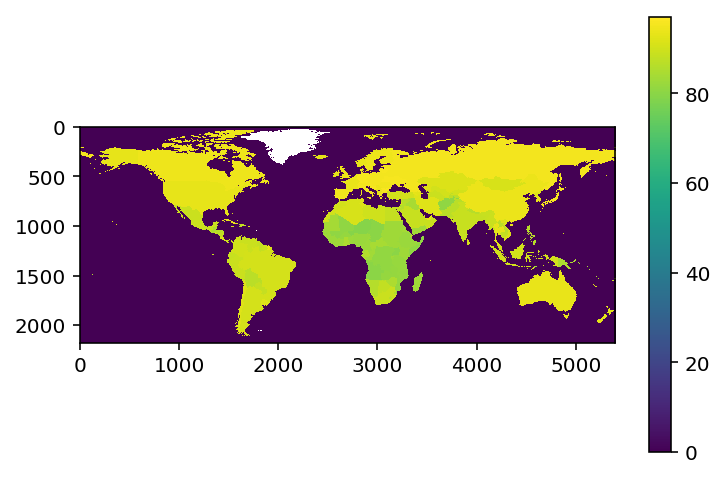

In [333]:
plt.imshow(raster, interpolation='nearest')
plt.colorbar()